In [ ]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 4.1MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp37-none-any.whl size=4120276 sha256=48ceff43a93d1bc0741bd9ee4f62eecd72d73880a3f65f636299056ed5a9d442
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib


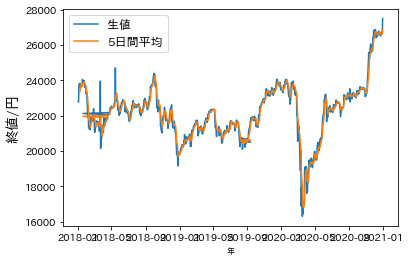

In [ ]:

#移動平均法で株価の平滑化
# 自己相関・偏自己相関の可視化
# 差分系列と単位根検定
# ARIMAモデルで予測

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib
import statsmodels.api as sm
from datetime import datetime

df=pd.read_csv("Nikkei_225.csv",encoding="shift-jis")
df["日付"].head()
d = list(map(lambda x:datetime.strptime(x, '%Y/%m/%d'), df["日付"]))

plt.plot(d,df["終値"],label="生値")
plt.xlabel('年', fontsize = 8)
plt.ylabel('終値/円', fontsize = 14)
plt.plot(d,df["終値"].rolling(5).mean(), label="5日間平均")
plt.legend(fontsize=12)


### 自己相関・偏自己相関の可視化
- 異なる時点での時系列データの相関関係を知るために自己相関係数を求める．
  - データの特徴を求めるのが目的．周期性とか？
- 相関が正の場合は1に近づき，無相関の場合には0に近づく．相関が負の場合には-1に近づく.
- 偏自己相関関数は時刻k，k-1，k-2のデータがある場合にk-1の影響なしにkとk-2の相関を比較できるようにしたもの．

In [ ]:
df["終値"]

0      22780
1      22780
2      23610
3      23810
4      23810
       ...  
773    26640
774    26600
775    26630
776    26880
777    27500
Name: 終値, Length: 778, dtype: int64

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '偏自己相関係数')

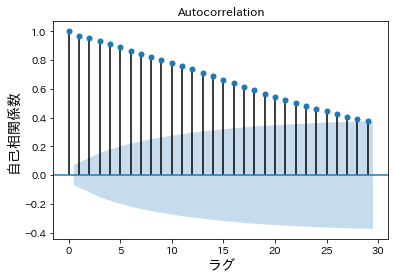

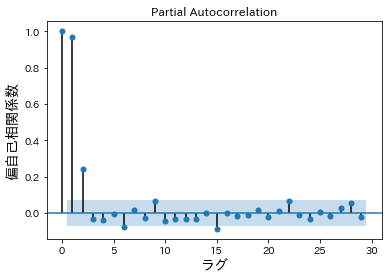

In [ ]:
#自己相関係数
acf=sm.tsa.stattools.acf(df["終値"])
#偏自己相関係数
pacf=sm.tsa.stattools.pacf(df["終値"], method="ols")

sm.graphics.tsa.plot_acf(df["終値"])
plt.xlabel('ラグ', fontsize=14)
plt.ylabel('自己相関係数', fontsize=14)

sm.graphics.tsa.plot_pacf(df["終値"])
plt.xlabel('ラグ', fontsize=14)
plt.ylabel('偏自己相関係数', fontsize=14)

# データにNaNがあるとうまくいかないので注意

### 差分系列と単位根検定
- 時間経過に対してデータがかわらないことを定常性という．
- 平均ゼロの周辺である分散をもってランダムに変化している状態．
- 株価は上昇傾向があるため，ランダム変化しているとは言いにくい．
- 解析を進めるために非定常な株価データを定常化する（上昇の長期トレンドを除く）．

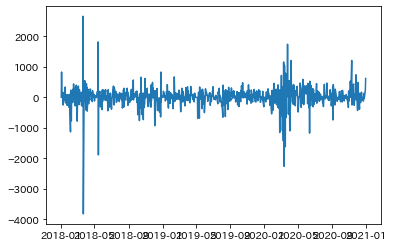

In [ ]:
close=df["終値"]
close_d=close.diff().dropna()
d=d[1:]
close_log = (1 + close.pct_change()).apply(np.log)
plt.plot(d,close_d)


In [ ]:
from statsmodels.tsa import stattools

#ADF検定
ctt = stattools.adfuller(close, regression='ctt')
ct = stattools.adfuller(close, regression='ct')
c = stattools.adfuller(close, regression='c')
nc = stattools.adfuller(close, regression='nc')

print(ctt[1], ct[1], c[1], nc[1])

0.24962153116330077 0.7578848542043499 0.6073545907535498 0.804000268457219


In [ ]:
from statsmodels.tsa import stattools

#ADF検定
ctt = stattools.adfuller(close_d, regression='ctt')
ct = stattools.adfuller(close_d, regression='ct')
c = stattools.adfuller(close_d, regression='c')
nc = stattools.adfuller(close_d, regression='nc')

print(ctt[1], ct[1], c[1], nc[1])
#ほぼゼロに近くなるので株価は定常過程

1.0149748483820417e-16 8.91779928049901e-17 7.513844521830634e-19 6.105982760215098e-19


### ARIMAモデルでの予測
- 株価は定常性があることがわかったのでARIMAモデルが使える．

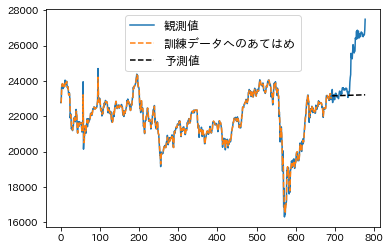

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
# 2018/1/2から2020/8/31までを学習にあてる
close_train=df["終値"].dropna()[:693]
model_d1 = ARIMA(close_train, (3, 1, 1))
# 学習データをもとに予測
results_d1=model_d1.fit()
res_d1=results_d1.resid

tup = results_d1.forecast(steps=85)
plt.plot(close.values, label = '観測値')
plt.plot(results_d1.predict(1, 692, typ='levels').values, '--', label="訓練データへのあてはめ")
plt.plot(range(693, 778), tup[0], "k--", label = '予測値')
plt.legend(fontsize = 12)

- 2020/8/31以降では全然予測ができていない．
- そもそも株価はランダムに変化しているので予測ができない？